# Papalexi2021 Preprocessing

In [6]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.stats.mstats import gmean
import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [5]:
%load_ext autoreload
%autoreload 2 

## Download

The dataset is taken from https://www.nature.com/articles/s41588-021-00778-2.

The raw data files can be donloaded here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE153056.

The following files were used for this notebook:
* mRNA counts: GSM4633614_ECCITE_cDNA_counts
* protein counts: GSM4633615_ECCITE_ADT_counts
* type of perturbation: ECCITE_metadata

Remark: An analysis of this dataset using Seurat can be found in https://satijalab.org/seurat/articles/mixscape_vignette.html.

## Transform csv to h5ad

convert tsv files for rna and adt counts to anndata h5ad

In [6]:
fname = 'GSM4633614_ECCITE_cDNA_counts'
raw_data_dir = "/storage/groups/ml01/workspace/kemal.inecik/Papalexi2021"

In [7]:
df = pd.read_csv(os.path.join(raw_data_dir, f'{fname}.tsv'), sep='\t')

In [8]:
df = df.T
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18639,18640,18641,18642,18643,18644,18645,18646,18647,18648
Unnamed: 0,AL627309.1,AP006222.2,RP4-669L17.10,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C,SAMD11,NOC2L,...,RP11-403P17.5,SMCR5,GRAPL,MIR451B,RP11-214C8.2,L3MBTL4,CTB-31O20.9,AC092295.4,MYO18B,TMPRSS3
l1_AAACCTGAGCCAGAAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGAGTGGACGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGCATGAGCGA,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGTCTTGTCAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.head()

Unnamed: 0,AL627309.1,AP006222.2,RP4-669L17.10,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C,SAMD11,NOC2L,...,RP11-403P17.5,SMCR5,GRAPL,MIR451B,RP11-214C8.2,L3MBTL4,CTB-31O20.9,AC092295.4,MYO18B,TMPRSS3
l1_AAACCTGAGCCAGAAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGAGTGGACGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGCATGAGCGA,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
l1_AAACCTGTCTTGTCAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l1_AAACGGGAGAACAACT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
sparse_df = csr_matrix(df.astype(np.float32))

In [11]:
df.columns.to_frame().rename(columns={'Unnamed: 0': 'Gene'}).reset_index(drop=True)

,Gene
0,AL627309.1
1,AP006222.2
2,RP4-669L17.10
3,RP11-206L10.3
4,RP11-206L10.2
...,...
18644,L3MBTL4
18645,CTB-31O20.9
18646,AC092295.4
18647,MYO18B


In [12]:
df.index.to_frame(name='cell_ID').reset_index(drop=True)

,cell_ID
0,l1_AAACCTGAGCCAGAAC
1,l1_AAACCTGAGTGGACGT
2,l1_AAACCTGCATGAGCGA
3,l1_AAACCTGTCTTGTCAT
4,l1_AAACGGGAGAACAACT
...,...
20724,l8_TTTGTCAGTCACTTCC
20725,l8_TTTGTCAGTGACGGTA
20726,l8_TTTGTCAGTTCCACAA
20727,l8_TTTGTCATCACGCATA


In [13]:
adata = ad.AnnData(
    X=sparse_df, 
    var=df.columns.to_frame().rename(columns={'Unnamed: 0': 'Gene'}).reset_index(drop=True), 
    obs=df.index.to_frame(name='cell_ID').reset_index(drop=True),
)

/home/icb/kemal.inecik/miniconda3/envs/mulpert/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
adata.write(os.path.join(raw_data_dir, f'{fname}.h5ad'))

## Merge h5ad files

In [15]:
fname = 'GSM4633614_ECCITE_cDNA_counts'
adata = ad.read(os.path.join(raw_data_dir, f'{fname}.h5ad'))
adata

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'cell_ID'
    var: 'Gene'

In [16]:
adata.var = adata.var.set_index('Gene')
adata.layers["counts"] = adata.X.copy()

In [17]:
metadata = pd.read_csv(os.path.join(raw_data_dir, 'GSE153056_ECCITE_metadata.tsv'), sep='\t')
adata.obs = metadata.rename(columns={'Unnamed: 0': 'cell_ID'}).set_index('cell_ID')
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nFeature_GDO,nCount_ADT,nFeature_ADT,percent.mito,...,guide_ID,guide_ID.global,gene,con,NT,crispr,replicate,S.Score,G2M.Score,Phase
cell_ID,,,,,,,,,,,,,,,,,,,,,
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99,4,576,111,801,4,2.295577,...,STAT2g2,Singlet,STAT2,tx,STAT2g2,Perturbed,rep1,-0.252716,-0.771844,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35,5,190,111,545,4,4.512939,...,CAV1g4,Singlet,CAV1,tx,CAV1g4,Perturbed,rep1,-0.123802,-0.335672,G1
l1_AAACCTGCATGAGCGA,Lane1,15256,4258,66,4,212,111,344,4,4.116413,...,STAT1g2,Singlet,STAT1,tx,STAT1g2,Perturbed,rep1,-0.154633,-0.693982,G1
l1_AAACCTGTCTTGTCAT,Lane1,5135,1780,22,3,243,111,539,4,5.491723,...,CD86g1,Singlet,CD86,tx,CD86g1,Perturbed,rep1,-0.061262,-0.035986,G1
l1_AAACGGGAGAACAACT,Lane1,9673,2671,99,5,198,111,1053,4,3.359868,...,IRF7g2,Singlet,IRF7,tx,IRF7g2,Perturbed,rep1,-0.132188,-0.356173,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l8_TTTGTCAGTCACTTCC,Lane8,20863,4884,294,4,290,111,398,4,5.469012,...,CMTM6g1,Singlet,CMTM6,tx,CMTM6g1,Perturbed,rep3,-0.323562,-0.797846,G1
l8_TTTGTCAGTGACGGTA,Lane8,17553,3787,528,3,870,111,3042,4,2.159175,...,NTg4,Singlet,NT,tx,NT,NT,rep2,-0.153514,-0.633978,G1
l8_TTTGTCAGTTCCACAA,Lane8,15106,4185,154,6,267,111,212,4,2.661194,...,ATF2g1,Singlet,ATF2,tx,ATF2g1,Perturbed,rep3,-0.191933,-0.578331,G1


In [18]:
fname = 'GSM4633615_ECCITE_ADT_counts'
protein_data = pd.read_csv(os.path.join(raw_data_dir, f'{fname}.tsv'), sep='\t')
protein_data = protein_data.T
protein_names = protein_data.iloc[0]
protein_data = protein_data[1:]
protein_data.columns = protein_names
protein_data

Unnamed: 0,CD86,PDL1,PDL2,CD366
l1_AAACCTGAGCCAGAAC,118,522,94,67
l1_AAACCTGAGTGGACGT,243,139,104,59
l1_AAACCTGCATGAGCGA,99,109,56,80
l1_AAACCTGTCTTGTCAT,110,334,48,47
l1_AAACGGGAGAACAACT,303,593,77,80
...,...,...,...,...
l8_TTTGTCAGTCACTTCC,98,151,135,14
l8_TTTGTCAGTGACGGTA,1781,1117,89,55
l8_TTTGTCAGTTCCACAA,84,73,38,17
l8_TTTGTCATCACGCATA,18,135,37,68


In [19]:
protein_data = protein_data.to_numpy(dtype=float)
protein_names = protein_names.to_numpy()
adata.uns['protein_names'] = protein_names
adata.obsm['protein_expression_raw'] = protein_data

In [20]:
adata

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    uns: 'protein_names'
    obsm: 'protein_expression_raw'
    layers: 'counts'

## Preprocess data

remove cells with low number of genes detected and log-normalize as in the paper

In [21]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [22]:
a=adata.var.copy()
a=a.sort_values(by=["dispersions_norm"])

for ind, i in enumerate(a['highly_variable']):
    if i:
        break
ind

15883

In [23]:
len(a)

18649

In [24]:
print(sum(a["highly_variable"]))

1917


In [25]:
sc.pp.highly_variable_genes(adata,n_top_genes=5000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [26]:
adata.X.A.max()

8.206335

for protein data use centered log-ratio (CLR) normalization, computed independently for each feature according to Seurat

In [27]:
def clr(x):
    return np.log(x) - np.log(gmean(x[x>0]))

In [28]:
adata.obsm['protein_expression'] = np.apply_along_axis(clr, 0, adata.obsm['protein_expression_raw'].astype(np.float32))

/tmp/ipykernel_262232/2739772620.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x) - np.log(gmean(x[x>0]))


In [29]:
adata.obsm['protein_expression'].max()

3.7426944

filter cells with inf values

In [30]:
adata = adata[~np.isinf(adata.obsm['protein_expression']).any(axis=1)]
adata

View of AnnData object with n_obs × n_vars = 20722 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'log1p', 'hvg'
    obsm: 'protein_expression_raw', 'protein_expression'
    layers: 'counts'

In [31]:
adata.write(os.path.join(raw_data_dir, f'Papalexi21_prep.h5ad'))

/home/icb/kemal.inecik/miniconda3/envs/mulpert/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/kemal.inecik/miniconda3/envs/mulpert/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Remove Outlier Genes

<AxesSubplot:ylabel='Count'>

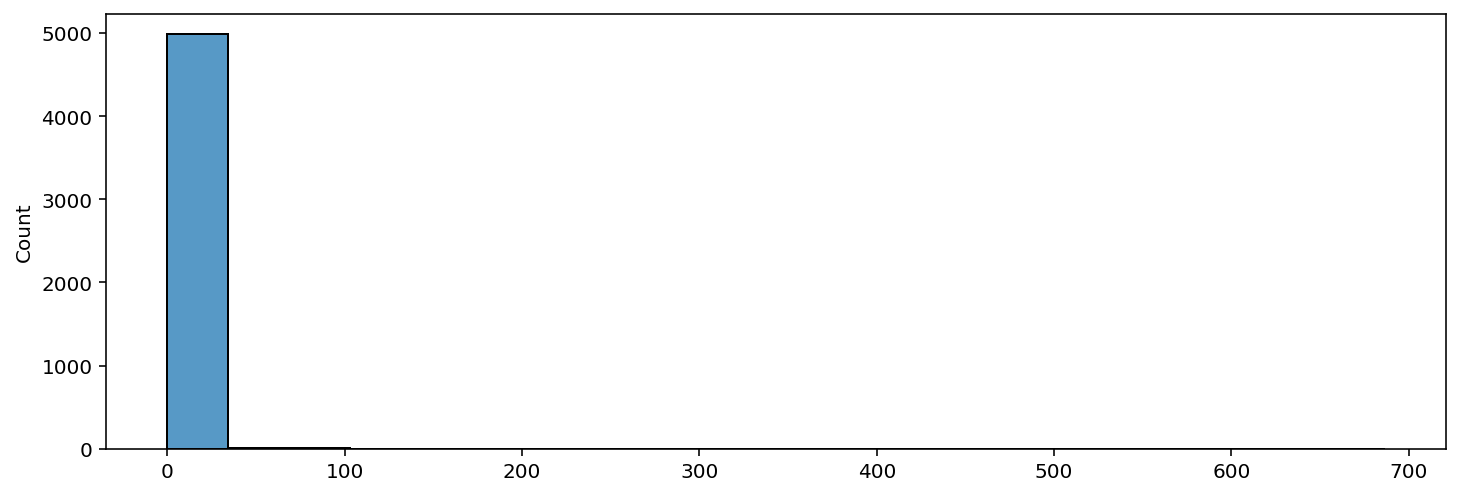

In [32]:
mean_genes = adata.layers['counts'].mean(0)
mean_genes = np.array(mean_genes)[0]
plt.figure(figsize=(12,4))
sns.histplot(sorted(mean_genes), bins=20)

In [33]:
THR = 75 
adata = adata[:, adata.var[mean_genes < THR].index]
adata

View of AnnData object with n_obs × n_vars = 20722 × 4993
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'log1p', 'hvg'
    obsm: 'protein_expression_raw', 'protein_expression'
    layers: 'counts'

In [34]:
adata.write(os.path.join(raw_data_dir, f'Papalexi21_prep.h5ad'))

# Visualization

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.pl.pca_scatter(adata, color=['nCount_RNA', 'n_genes', 'percent.mito'])
sc.pl.umap(adata, color=['nCount_RNA', 'n_genes', 'percent.mito'])

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
sc.pl.umap(adata, color=['gene', 'crispr', 'Phase'], size=20)

In [ ]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color='louvain')

In [ ]:
adata

In [ ]:
adata.write(os.path.join(raw_data_dir, f'Papalexi21_prep.h5ad'))

# Prepare for the model

In [35]:
np.unique(adata.obs["gene"])

array(['ATF2', 'BRD4', 'CAV1', 'CD86', 'CMTM6', 'CUL3', 'ETV7', 'IFNGR1',
       'IFNGR2', 'IRF1', 'IRF7', 'JAK2', 'MARCH8', 'MYC', 'NFKBIA', 'NT',
       'PDCD1LG2', 'POU2F2', 'SMAD4', 'SPI1', 'STAT1', 'STAT2', 'STAT3',
       'STAT5A', 'TNFRSF14', 'UBE2L6'], dtype=object)

In [36]:
adata.obs['dose_val'] = 1.0
adata.obs['cell_type'] = 'THP-1'
adata.obs['drug_dose_name'] = adata.obs.gene.astype(str) + '_' + adata.obs.dose_val.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)
adata.obs['condition'] = adata.obs.gene.copy()
adata.obs['control'] = [1 if x == 'NT_1.0' else 0 for x in adata.obs.drug_dose_name.values]

/tmp/ipykernel_262232/1025521670.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dose_val'] = 1.0


In [37]:
from MultiCPA.helper import rank_genes_groups_by_cov

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', pd.errors.PerformanceWarning)
    rank_genes_groups_by_cov(adata, groupby='cov_drug_dose_name', covariate='cell_type', control_group='NT_1.0')

THP-1
ranking genes


/home/icb/kemal.inecik/miniconda3/envs/mulpert/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [39]:
np.unique(adata.obs["cov_drug_dose_name"])

array(['THP-1_ATF2_1.0', 'THP-1_BRD4_1.0', 'THP-1_CAV1_1.0',
       'THP-1_CD86_1.0', 'THP-1_CMTM6_1.0', 'THP-1_CUL3_1.0',
       'THP-1_ETV7_1.0', 'THP-1_IFNGR1_1.0', 'THP-1_IFNGR2_1.0',
       'THP-1_IRF1_1.0', 'THP-1_IRF7_1.0', 'THP-1_JAK2_1.0',
       'THP-1_MARCH8_1.0', 'THP-1_MYC_1.0', 'THP-1_NFKBIA_1.0',
       'THP-1_NT_1.0', 'THP-1_PDCD1LG2_1.0', 'THP-1_POU2F2_1.0',
       'THP-1_SMAD4_1.0', 'THP-1_SPI1_1.0', 'THP-1_STAT1_1.0',
       'THP-1_STAT2_1.0', 'THP-1_STAT3_1.0', 'THP-1_STAT5A_1.0',
       'THP-1_TNFRSF14_1.0', 'THP-1_UBE2L6_1.0'], dtype=object)

In [40]:
adata.uns["rank_genes_groups_cov"].keys()

dict_keys(['THP-1_ATF2_1.0', 'THP-1_BRD4_1.0', 'THP-1_CAV1_1.0', 'THP-1_CD86_1.0', 'THP-1_CMTM6_1.0', 'THP-1_CUL3_1.0', 'THP-1_ETV7_1.0', 'THP-1_IFNGR1_1.0', 'THP-1_IFNGR2_1.0', 'THP-1_IRF1_1.0', 'THP-1_IRF7_1.0', 'THP-1_JAK2_1.0', 'THP-1_MARCH8_1.0', 'THP-1_MYC_1.0', 'THP-1_NFKBIA_1.0', 'THP-1_PDCD1LG2_1.0', 'THP-1_POU2F2_1.0', 'THP-1_SMAD4_1.0', 'THP-1_SPI1_1.0', 'THP-1_STAT1_1.0', 'THP-1_STAT2_1.0', 'THP-1_STAT3_1.0', 'THP-1_STAT5A_1.0', 'THP-1_TNFRSF14_1.0', 'THP-1_UBE2L6_1.0'])

In [41]:
adata.write(os.path.join(raw_data_dir, f'Papalexi21_prep.h5ad'))

In [42]:
adata

AnnData object with n_obs × n_vars = 20722 × 4993
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'log1p', 'hvg', 'rank_genes_groups_cov'
    obsm: 'protein_expression_raw', 'protein_expression'
    layers: 'counts'

# Splits

In [43]:
adata.obs.groupby(['gene']).size().sort_values(ascending=False)

gene
NT          2385
IFNGR1      1341
IFNGR2      1212
CD86        1197
ATF2        1102
IRF1        1073
JAK2        1024
MARCH8      1003
TNFRSF14     962
CAV1         882
ETV7         841
CMTM6        817
NFKBIA       787
STAT2        661
POU2F2       661
STAT5A       659
SMAD4        659
PDCD1LG2     617
IRF7         614
UBE2L6       518
STAT3        493
STAT1        443
BRD4         341
CUL3         274
MYC          109
SPI1          47
dtype: int64

In [44]:
sum(adata.obs.groupby(['gene']).size())

20722

In [45]:
adata.obs['split'] = 'nan'
for cov_drug_dose_name in np.unique(adata.obs["cov_drug_dose_name"]):
    adata_idx = adata.obs_names[adata.obs["cov_drug_dose_name"] == cov_drug_dose_name]
    # print(f"{cov_drug_dose_name}\t{len(adata_idx)}")
    adata_idx_train, adata_idx_test = train_test_split(adata_idx, test_size=0.15, random_state=42)
    adata.obs.loc[adata_idx_train, 'split'] = 'train'
    adata.obs.loc[adata_idx_test, 'split'] = 'test'
adata_idx = adata.obs_names
_, adata_idx_ood = train_test_split(adata_idx, test_size=0.0003, random_state=42)
adata.obs.loc[adata_idx_ood, 'split'] = 'ood'


In [46]:
adata.obs.groupby('split').size()

split
ood          7
test      3122
train    17593
dtype: int64

### ood selection - DEPRECATED

stat2 can be a nice ood considering we have stat1 and stat3 in the dataset.

IFNGR1 can be a nice ood considering we have IFNGR2 in the dataset. but stat2 is a part of the pathway anyway.

SPI1 and MYC as there are low number of them and downstream TFs of the others.

In [ ]:
for cov_drug_dose_name in ["THP-1_MYC_1.0", "THP-1_STAT2_1.0", "THP-1_SPI1_1.0"]:
    adata_idx = adata.obs_names[adata.obs["cov_drug_dose_name"] == cov_drug_dose_name]
    print(f"{cov_drug_dose_name}\t{len(adata_idx)}")
    adata.obs.loc[adata_idx, 'split'] = 'ood'

In [ ]:
# remove control cells from ood data
adata_idx_ = adata[(adata.obs['gene'] == 'NT') & (adata.obs['split'] == 'ood')].obs_names
adata.obs['split'].loc[adata_idx_] = 'test'

In [ ]:
adata.obs.groupby(['split']).size()

In [ ]:
pd.set_option('display.max_rows', 100)
adata.obs.groupby(['split', 'gene']).size()

# Cleanup

In [47]:
adata

AnnData object with n_obs × n_vars = 20722 × 4993
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'log1p', 'hvg', 'rank_genes_groups_cov'
    obsm: 'protein_expression_raw', 'protein_expression'
    layers: 'counts'

In [48]:
adata.write(os.path.join(raw_data_dir, f'Papalexi21_prep.h5ad'))

In [49]:
import time
time.time()

1650981275.1730063